In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# Define the model
from net import Net

# Optimizer and loss function
import torch.optim as optim
import torch.nn as nn

## Définition des fonctions

In [2]:
# indicates that "1" means "face" and "0" non-face
classes = ('noface', 'face')

# Defining the folder path
train_dir = './train_images'    # folder containing training images
test_dir = './test_images'    # folder containing test images

# Define the functions

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# function to switch to cuda if available
def switch_to_cuda(model):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        model.to(device)
        print("switch to cuda")
        return True, device
    print("cuda not available")
    return False, None


# function to train the model with GPU
def train_GPU(model, train_loader, criterion, optimizer, epochs, device):
    for epoch in range(1, epochs+1):
        # Mode d'entraînement
        model.train()
        running_loss = 0.0
        for data, target in train_loader:

            # Passage en mode CUDA
            data, target = data.to(device), target.to(device)
            # Mise à zéro des gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data)
            # Calcul de la perte
            loss = criterion(outputs, target)
            # Backpropagation et mise à jour des poids
            loss.backward()
            optimizer.step()
            # Suivi de la perte
            running_loss += loss.item()

        # Affichage de la perte moyenne de l'époque
        print(f'Epoch {epoch}, Loss: {running_loss / len(train_loader)}')

    print('Finished Training')

# function to train model with CPU
def train_CPU(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(1, epochs+1):
        # Mode d'entraînement
        model.train()
        running_loss = 0.0
        for data, target in train_loader:

            # Mise à zéro des gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data)
            # Calcul de la perte
            loss = criterion(outputs, target)
            # Backpropagation et mise à jour des poids
            loss.backward()
            optimizer.step()
            # Suivi de la perte
            running_loss += loss.item()

        # Affichage de la perte moyenne de l'époque
        print(f'Epoch {epoch}, Loss: {running_loss / len(train_loader)}')
    print('Finished Training')

# function to measure the accuracy of the model
def accuracy(model, test_loader):
    model.to(torch.device("cpu"))
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

# function to measure the accuracy of the model for each class
def accuracy_per_class(model, test_loader):
    model.to(torch.device("cpu"))
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            # data = data.to(device)
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


# Matrices de confusion
def confusion_matrix(model, test_loader):
    model.to(torch.device("cpu"))
    nb_classes = 2
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)

## Preparing environment and data

In [5]:
# Transforming the images for the neural network
transform = transforms.Compose(
    [transforms.Grayscale(),   # transforms to gray-scale (1 input channel)
     transforms.ToTensor(),    # transforms to Torch tensor (needed for PyTorch)
     transforms.Normalize(mean=(0.5,), std=(0.5,))])  # subtracts mean (0.5) and devides by standard deviation (0.5) -> resulting values in (-1, +1)

# Define two pytorch datasets (train/test)
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 32 

# Define randomly the indices of examples to use for training and for validation
num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:], indices_train[:split_tv]

# Define two "samplers" that will randomly pick examples from the training and validation set
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders (take care of loading the data from disk, batch by batch, during training)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, num_workers=1)

### Data visualization

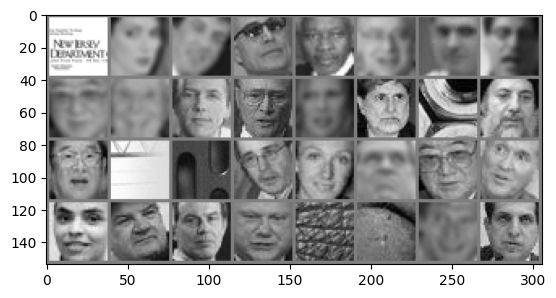

noface face  face  face  face  face  face  face  face  face  face  face  face  face  noface face  face  noface noface face  face  face  face  face  face  face  face  face  noface noface face  face 


In [6]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## Modèle original

### Training

In [13]:
# Instance of the model
model = Net()
# Model summary
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
n_epochs = 3  # Nb of epochs

cuda = switch_to_cuda(model)  # Switch to cuda if available

if cuda:
    train_GPU(model, train_loader, criterion, optimizer, n_epochs)
else:
    train_CPU(model, train_loader, criterion, optimizer, n_epochs)

cuda not available
Epoch 1, Loss: 0.30590005462759323
Epoch 2, Loss: 0.08095116161294948
Epoch 3, Loss: 0.039860303742576327
Finished Training


### Evaluation

In [16]:
# Evaluation
model.eval()

# Accuracy
accuracy(model, test_loader)

# Accuracy per class
accuracy_per_class(model, test_loader)

Accuracy of the network on the 10000 test images: 92 %
Accuracy for class: noface is 98.2 %
Accuracy for class: face  is 39.5 %


## Weight

In [4]:
#  Weight face data
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)
n_epochs = 3  # Nb of epochs
# Define your class weights
weight_for_face = 5.0
class_weights = torch.tensor([1.0, weight_for_face])
criterion = nn.CrossEntropyLoss(weight=class_weights)


cuda = switch_to_cuda(model)

if cuda:
    train_GPU(model, train_loader, criterion, optimizer, n_epochs)
else:
    train_CPU(model, train_loader, criterion, optimizer, n_epochs)

cuda not available
Epoch 1, Loss: 0.1939981686247036
Epoch 2, Loss: 0.06617774704653596
Epoch 3, Loss: 0.0449690333095603
Finished Training


In [5]:
# Evaluation
model.eval()

# Accuracy
accuracy(model, test_loader)

# Accuracy per class
accuracy_per_class(model, test_loader)

Accuracy of the network on the 10000 test images: 86 %
Accuracy for class: noface is 90.9 %
Accuracy for class: face  is 51.4 %


## Data augmentation & Modification architecture

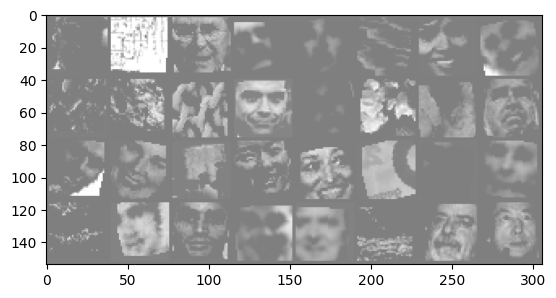

face  noface face  face  face  noface face  face  noface noface noface face  face  noface noface face  face  face  noface face  face  noface face  face  noface face  face  face  face  noface face  face 


In [3]:
# Data augmentation transformation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    # New transformations
    transforms.RandomRotation(degrees=15),  # Random rotation of -15° to +15°
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    # Random translation of -10% to +10% on both axes
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # Luminosity and contrast jitter
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

# Define two pytorch datasets (train/test)
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 32

# Define randomly the indices of examples to use for training and for validation
num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:], indices_train[:split_tv]

# Define two "samplers" that will randomly pick examples from the training and validation set
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders (take care of loading the data from disk, batch by batch, during training)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, num_workers=1)

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [4]:
# Instance of the model
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
n_epochs = 10  # Nb of epochs
cuda, device = switch_to_cuda(model)  # Switch to cuda if available

if cuda:
    train_GPU(model, train_loader, criterion, optimizer, n_epochs, device)
else:
    train_CPU(model, train_loader, criterion, optimizer, n_epochs)

# Evaluation
model.eval()
accuracy(model, test_loader)
accuracy_per_class(model, test_loader)
confusion_matrix(model, test_loader)

cuda not available
Epoch 1, Loss: 0.28897655090805335
Epoch 2, Loss: 0.1343314945356611
Epoch 3, Loss: 0.10604753418562782
Epoch 4, Loss: 0.0904794431559484
Epoch 5, Loss: 0.0812491067890094
Epoch 6, Loss: 0.07711861221597201
Epoch 7, Loss: 0.07291458923426711
Epoch 8, Loss: 0.06566968250118957
Epoch 9, Loss: 0.06313146171038703
Epoch 10, Loss: 0.06068216319269745
Finished Training
Accuracy of the network on the 10000 test images: 94 %
Accuracy for class: noface is 95.7 %
Accuracy for class: face  is 84.3 %
tensor([[6536.,  295.],
        [ 127.,  670.]])


In [5]:
# Evaluation
model.eval()

# Accuracy
accuracy(model, test_loader)

# Accuracy per class
accuracy_per_class(model, test_loader)

# confusion matrix
confusion_matrix(model, test_loader)

Accuracy of the network on the 10000 test images: 94 %
Accuracy for class: noface is 95.7 %
Accuracy for class: face  is 85.6 %
tensor([[6538.,  293.],
        [ 129.,  668.]])


In [ ]:
# Save the model
PATH = './model_2.pth'
torch.save(model.state_dict(), PATH)